# Spacecraft Pose Estimation Model Example

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/My Drive/spacecraft-pose-estimation/model

/content/drive/My Drive/spacecraft-pose-estimation/model


In [3]:
%matplotlib inline
USE_GPU = True

In [4]:
from matplotlib import pyplot as plt
import numpy as np
from random import randint
from dataloader_utils import *
torch.manual_seed(42)
from PIL import Image, ImageDraw
from matplotlib import cm
import torchvision.transforms.functional as tF

if USE_GPU:
    print(torch.cuda.is_available())

True


## Testing dataloader

In [5]:
dataset_root_dir = '../../speed'
annotations_root_dir = '../annotations'

sample_transform = transforms.Compose([
    transforms.RandomRotation((-30, 30))
])

sample_dataset = SpeedDataset(speed_root=dataset_root_dir, annotations_root=annotations_root_dir, transform=None)

Bounding box [x_min, y_min, x_max, y_max]: [571.89217841 547.14270504 901.62193347 509.08239738]


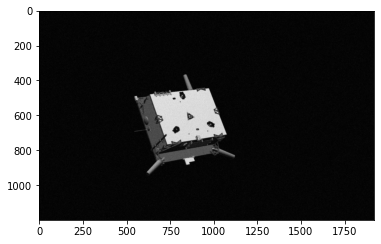

In [6]:
i = 895
img, label, _ = sample_dataset[i]
plt.figure()
plt.imshow(img)
print("Bounding box [x_min, y_min, x_max, y_max]: {}".format(label[-4:]))

## Dataloading

In [7]:
class JointRescrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, target):
        target_q = target[:4]
        target_r = target[4:7]
        target_db = target[7:11] 
        target_bb = target[11:]

        sz = self.size[0]
        # Determine crop size that will still capture entire satellite
        x = [target_bb[i] for i in range(0, len(target_bb), 2)]
        y = [target_bb[i] for i in range(1, len(target_bb), 2)]
        xmin = min(x); xmax = max(x)
        ymin = min(y); ymax = max(y)
        fS = 1.75
        dx = xmax - xmin
        dy = ymax - ymin
        self.cropSize = int(fS * max(dx, dy))
        if self.cropSize > min(img.size):
            self.cropSize = min(img.size)
#         print("cropSize: ", cropSize)
        
        # Crop Image
        self.cx = sum(x)/len(x)
        self.cy = sum(y)/len(y)
        top = self.cy - self.cropSize/2
        left = self.cx - self.cropSize/2
        img = tF.crop(img, top, left, self.cropSize, self.cropSize)
        
        # Crop translation of points
        xtarget = [self.cropSize/2 + (i - self.cx) for i in x]
        ytarget = [self.cropSize/2 + (i - self.cy) for i in y]
        target_bb = [None]*(len(xtarget)+len(ytarget))
        target_bb[::2] = xtarget
        target_bb[1::2] = ytarget
        target_bb = np.array(target_bb)
        
        # Rescale to input size
        norm = img.size[1]
        img = tF.resize(img, sz)
        target_bb = [sz * i / norm for i in target_bb]
        target = np.concatenate((target_q, target_r, target_db, target_bb))

        return img, target

In [8]:
class JointToTensor(object):
    def __call__(self, img, target):
        return tF.to_tensor(img), torch.from_numpy(target)

In [9]:
class JointCompose(object):
    def __init__(self, transforms):
        """
        params: 
           transforms (list) : list of transforms
        """
        self.transforms = transforms

    # We override the __call__ function such that this class can be
    # called as a function i.e. JointCompose(transforms)(img, target)
    # Such classes are known as "functors"
    def __call__(self, img, target):
        """
        params:
            img (PIL.Image)    : input image
            target (PIL.Image) : ground truth label 
        """
        for t in self.transforms:
            img, target = t(img, target)
        return img, target

In [10]:
# Transforms
train_transform = JointCompose([
    JointRescrop((256,256)),
    JointToTensor(),
])

sanity_transform = JointCompose([
    JointRescrop((256,256)),
    JointToTensor(),
])

val_transform = JointCompose([
    JointRescrop((256,256)),
    JointToTensor(),
])

In [11]:
# Datasets
# NOTE: we don't have the labels for the test set, so we need to split the training set
training_dataset = SpeedDataset(
    split="train",
    split_index=1000, # used to make a smaller training set for dev
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=train_transform
)

sanity_dataset = SpeedDataset(
    split="train",
    sanity_check=100,
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=sanity_transform
)

[116.8966379564547, 141.97702432584282]

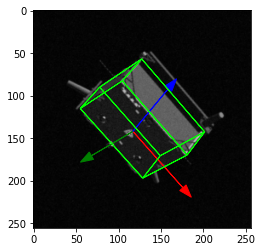

In [12]:
# TEST
sample, target, K = training_dataset[17]
image1, label1 = JointRescrop((256, 256))(tF.to_pil_image(sample), target.numpy())
training_dataset.visualize(image1, label1, K, factor=0.6, bbox=True)

In [13]:
(train_len, test_len) = (int(0.85*len(training_dataset)), int(0.15*len(training_dataset)))
assert train_len + test_len == len(training_dataset)
train_dataset, test_dataset = torch.utils.data.random_split(training_dataset, (train_len, test_len))

In [14]:
# Dataloading
WORKERS=6
train_loader = DataLoader(train_dataset, batch_size=16, num_workers=WORKERS, shuffle=False, drop_last=True) # NOTE: set shuffle to True!
sanity_loader = DataLoader(sanity_dataset, batch_size=1, num_workers=WORKERS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=WORKERS, shuffle=False, drop_last=True)

## Existing network implementations (1/2)

The following is a pytorch implementation of [Deep3dBox](https://arxiv.org/pdf/1612.00496.pdf). Geometric constraints are used to solve for the translation (even though it is known to lock errors in if the 2D bounding box is inaccurate; see [MonoPSR](https://arxiv.org/pdf/1904.01690.pdf) or [Cascade geometric constratins](https://arxiv.org/pdf/1909.01867.pdf) for better alternatives). However, all these approaches focus on 3D bounding box estimation for cars and as a result, they can make pretty big assumptions about the orientation of the vehicle (i.e., roll and pitch equal to zero). These papers use multi-task CNN and multi-bin losses and would need to be extended to recover the full 6DOF.

In [15]:
# Pre-trained layers
DEEP3D = False
if DEEP3D:
    vgg = models.vgg19_bn(pretrained=True)

In [16]:
# Input size: 224x224 (imposed by vgg pretrained layers)

def OrientationLoss(orient_batch, orientGT_batch, confGT_batch):

    batch_size = orient_batch.size()[0]
    indexes = torch.max(confGT_batch, dim=1)[1]

    # extract just the important bin
    orientGT_batch = orientGT_batch[torch.arange(batch_size), indexes]
    orient_batch = orient_batch[torch.arange(batch_size), indexes]

    theta_diff = torch.atan2(orientGT_batch[:,1], orientGT_batch[:,0])
    estimated_theta_diff = torch.atan2(orient_batch[:,1], orient_batch[:,0])

    return -1 * torch.cos(theta_diff - estimated_theta_diff).mean()


class Deep3dBoxNet(nn.Module):
    def __init__(self, features=None, bins=2, w = 0.4):
        super(Deep3dBoxNet, self).__init__()
        self.bins = bins
        self.w = w
        self.features = features
        self.orientation = nn.Sequential(
                    nn.Linear(512 * 7 * 7, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, bins*2) # to get sin and cos
                )
        self.confidence = nn.Sequential(
                    nn.Linear(512 * 7 * 7, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, bins),
                    # nn.Softmax()
                    #nn.Sigmoid()
                )
        self.dimension = nn.Sequential(
                    nn.Linear(512 * 7 * 7, 512),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(512, 512),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(512, 3)
                )

    def forward(self, x):
        x = self.features(x) # 512 x 7 x 7
        x = x.view(-1, 512 * 7 * 7)
        orientation = self.orientation(x)
        orientation = orientation.view(-1, self.bins, 2)
        orientation = F.normalize(orientation, dim=2)
        confidence = self.confidence(x)
        dimension = self.dimension(x)
        return orientation, confidence, dimension

In [17]:
# Testing model with pretrained weights (epoch10) on Kitti
if DEEP3D:
    weight_filepath = '../weights/epoch_10.pkl'
    if USE_GPU == True:
        model = Deep3dBoxNet(features=vgg.features, bins=2).cuda()
    else:
        model = Deep3dBoxNet(features=vgg.features, bins=2)
    checkpoint = torch.load(weight_filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    # model.eval()

## Existing network implementations (2/2)
The following is an end-to-end implementation based on [USRO](https://arxiv.org/pdf/1907.04298.pdf) which seeks simplicity over efficiency. The team finished in 3rd place using resnet101 as their backbone. This implementation relies on resnet34 instead for computational reasons. Being more straightforward, this implementation is more suited to a study of domain adaptation.

In [18]:
# Pre-trained layers
resnet = models.resnet34(pretrained=True)

In [19]:
class URSONet(nn.Module):
    def __init__(self, criterion=None):
        super(URSONet, self).__init__()

        # Resnet backbone
        self.resnet = nn.Sequential(*list(resnet.children())[:-2]) 
        self.conv6 = nn.Conv2d(512, 1024, 3, 2)
        self.bn1 = nn.BatchNorm2d(1024)
        
        # Translation branch: t = [tx, ty, tz]
        # self.fc_t = nn.Linear(4*4*1024, 3)
        # self.fc_t1 = nn.Linear(3*3*1024, 1024)
        # self.fc_t2 = nn.Linear(1024, 3)

        # Attitude branch: q = [q0, q1, q2, q3]
        # self.fc_att = nn.Linear(4*4*1024, 4)
        self.fc_att1 = nn.Linear(3*3*1024, 1024)
        self.fc_att2 = nn.Linear(1024, 4) # unit-quaternions or axis-angle
        # self.fc_att2 = nn.Linear(1024, 3) # MRP or Euler angles        
    
    def forward(self, input, gt=None):
        # Input size: 256x256
        # x = F.relu(self.resnet(input)) # NOTE: should we add activation after resnet?
        x = self.resnet(input)
        x = F.relu(self.bn1(self.conv6(x)))
        # Reshape after bottleneck
        # x_t = x.view(-1, 3*3*1024)
        x_att = x.view(-1, 3*3*1024)

        # T regression
        # x_t = F.relu(self.fc_t1(x_t))
        # x_t = self.fc_t2(x_t)

        # q regression
        x_att = F.relu(self.fc_att1(x_att))
        x_att = self.fc_att2(x_att)

        # return x_t, x_att
        return x_att

### Training

In [20]:
OVERFIT=False
TRAINING=True
if OVERFIT:
    overfit_net = URSONet()
    if USE_GPU:
        overfit_net = overfit_net.cuda()

In [21]:
def get_of_optimizer(net):
    # optimizer = torch.optim.Adam(net.parameters())
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.001,
                                weight_decay=0.0001,
                                momentum=0.9)
    return optimizer

In [22]:
def q_to_mrp(q):
    bs =  q.shape[0]
    mrp = q[:,1:4] / (1 + q[:,0].reshape(bs,1))
    return mrp

In [23]:
def mrp_to_q(sigma):
    s2 = torch.norm(sigma)**2
    q0 = torch.tensor([(1-s2)/(1+s2)])
    qi = 2*sigma/(1+s2)
    q = np.concatenate((q0.detach().cpu().numpy(),qi.detach().cpu().numpy()[0]), 0)
    return q

In [24]:
def q_to_aa(q):
    a = q[:,0]
    x = q[:,1:]
    theta = 2 * torch.atan2(torch.norm(x,dim=1), a)
    theta[theta > np.pi] -= 2*np.pi
    idx = (theta != 0)
    v = x / torch.sin(theta[:,None]/2) 
    v[~idx] = 0
    return v, theta

In [53]:
def aa_to_q(v, theta):
  a = torch.cos(theta/2)
  x = v * torch.sin(theta[:,None]/2)
  bs = len(a)
  q = torch.zeros(bs,4)
  q[:,0] = a
  q[:,1:] = x
  return q

In [26]:
def aa_loss(theta_pred, v_pred, theta_gt, v_gt):
  bs = len(theta_pred)
  theta_pred = [(i+np.pi) % (2*np.pi) - np.pi for i in theta_pred]  # Adjust to be in range from -pi to pi
  theta_pred = torch.stack(theta_pred)
  diff = torch.abs(torch.sub(theta_gt, theta_pred)) 
  idx = diff > np.pi
  diff = (2*np.pi-diff)*idx + diff*(~idx)
  theta_error = torch.sum(torch.abs(diff))
  v_error = torch.sum(torch.abs(v_gt - v_pred))

  loss = (theta_error + v_error) / bs
  return loss

In [27]:
def translation_loss(t_gt, t_pred):
    return torch.mean(torch.norm((t_gt - t_pred)/torch.norm(t_gt)))
    # return torch.mean(torch.cdist(t_gt, t_pred, p=2))


In [28]:
def attitude_loss(att_gt, att_pred):
    bs = att_gt.shape[0]
    att_pred = F.normalize(att_pred, p=2, dim=1)
    prod = torch.bmm(att_gt.view(bs, 1, 4), att_pred.view(bs, 4, 1)).reshape(bs, 1)
    loss = 1 - prod ** 2
    # sigma = att_gt[0][1:4] / (1 + att_gt[0][0])
    # s2 = torch.norm(sigma) ** 2
    # if s2 > 1.0:
    #     sigma /= -s2
    # return torch.sum(torch.norm(sigma[None] - att_pred, p=2))
    return torch.mean(loss)


In [29]:
def mrp_loss(att_gt, att_pred):
    bs = att_gt.shape[0]
    sigma = att_gt[:,1:4] / (1 + att_gt[:,0].reshape(bs,1))
    # s2 = torch.norm(sigma) ** 2
    # if s2 > 1.0:
    #     sigma /= -s2
    loss = torch.sum(torch.norm(sigma - att_pred, dim=1))
    return loss

In [30]:
def euler321_to_dcm(th_1, th_2, th_3):
    dcm = np.zeros((3, 3))
    dcm[0][0] = np.cos(th_1)*np.cos(th_2)
    dcm[0][1] = np.sin(th_1)*np.cos(th_2)
    dcm[0][2] = -np.sin(th_2)
    dcm[1][0] = -np.sin(th_1)*np.cos(th_3) + np.cos(th_1)*np.sin(th_2)*np.sin(th_3)
    dcm[1][1] = np.cos(th_1)*np.cos(th_3) + np.sin(th_1)*np.sin(th_2)*np.sin(th_3)
    dcm[1][2] = np.cos(th_2)*np.sin(th_3)
    dcm[2][0] = np.sin(th_1)*np.sin(th_3) + np.cos(th_1)*np.sin(th_2)*np.cos(th_3)
    dcm[2][1] = -np.cos(th_1)*np.sin(th_3) + np.sin(th_1)*np.sin(th_2)*np.cos(th_3)
    dcm[2][2] = np.cos(th_2)*np.cos(th_3)

    return dcm

In [31]:
def dcm_to_q(dcm):
    q0 = -0.5*np.sqrt(dcm[0][0]+dcm[1][1]+dcm[2][2]+1)
    q1 = (dcm[1][2]-dcm[2][1])/(4*q0)
    q2 = (dcm[2][0]-dcm[0][2])/(4*q0)
    q3 = (dcm[0][1]-dcm[1][0])/(4*q0)

    return [q0, q1, q2, q3]


In [32]:
def dcm_to_euler321_batch(dcm):
    bs = int(dcm.shape[0]/3)

    e = torch.Tensor(np.zeros((bs, 3)))
    for i in range(0,bs):
      e[i][1] = -np.arcsin(dcm[3*i+0][2])
      e[i][0] = np.arctan2(dcm[3*i+0][1],dcm[3*i+0][0])
      e[i][2] = np.arctan2(dcm[3*i+1][2],dcm[3*i+2][2])

    return e

In [33]:
def quat2dcm_batch(q):

    """ Computing direction cosine matrix from quaternion, adapted from PyNav. """
    # Ground truth quaternion will be normalized already
    bs = q.shape[0]

    dcm = torch.Tensor(np.zeros((3*bs, 3)))
    for i in range(0,bs):
      q0 = q[i].detach().cpu().numpy()[0]
      q1 = q[i].detach().cpu().numpy()[1]
      q2 = q[i].detach().cpu().numpy()[2]
      q3 = q[i].detach().cpu().numpy()[3]

      dcm[3*i+0, 0] = 2 * q0 ** 2 - 1 + 2 * q1 ** 2
      dcm[3*i+1, 1] = 2 * q0 ** 2 - 1 + 2 * q2 ** 2
      dcm[3*i+2, 2] = 2 * q0 ** 2 - 1 + 2 * q3 ** 2

      dcm[3*i+0, 1] = 2 * q1 * q2 + 2 * q0 * q3
      dcm[3*i+0, 2] = 2 * q1 * q3 - 2 * q0 * q2

      dcm[3*i+1, 0] = 2 * q1 * q2 - 2 * q0 * q3
      dcm[3*i+1, 2] = 2 * q2 * q3 + 2 * q0 * q1

      dcm[3*i+2, 0] = 2 * q1 * q3 + 2 * q0 * q2
      dcm[3*i+2, 1] = 2 * q2 * q3 - 2 * q0 * q1

    return dcm

In [34]:
def eulerLoss(e_gt, e_pred): # Euler angles in radians
    bs = e_gt.shape[0]
    e_pred = [(i+np.pi) % (2*np.pi) - np.pi for i in e_pred]
    e_pred = torch.stack(e_pred)
    # print("e_gt:", e_gt)
    # print("e_pred:", e_pred)

    loss = 0
    diff = torch.abs(torch.sub(e_gt, e_pred))
    # print("diff: ", diff)

    idx = diff > np.pi
    diff = (2*np.pi-diff)*idx + diff*(~idx)
    # print("diff new: ", diff)

    loss += torch.sum(diff)
    # print("torch loss: ", loss)
    loss_mean = loss/bs
    # print("torch mean loss: ", loss_mean)

    return loss_mean

In [35]:
def train(train_loader, net, optimizer, loss_graph):
    epoch_loss = 0
    for i, data in enumerate(train_loader):
        inputs, target, _ = data
        if USE_GPU:
            inputs = inputs.cuda()
            target = target.cuda()
        att_gt = target[:, :4].float()
        v_gt, theta_gt = q_to_aa(att_gt)

        # dcm_gt = quat2dcm_batch(att_gt)
        # e_gt = dcm_to_euler321_batch(dcm_gt)
        # e_gt = e_gt.to(device='cuda')
        # t_gt = target[:, 4:7].float()

        optimizer.zero_grad() 
        # t, att = net(inputs)
        att = net(inputs)
        theta_pred = att[:,0]
        v_pred = att[:,1:]

        # L_t = translation_loss(t_gt, t)
        # L_att = eulerLoss(e_gt, att)
        # print("network pred: ", att)
        # L_att = mrp_loss(att_gt, att)
        L_att = aa_loss(theta_pred, v_pred, theta_gt, v_gt)

        # total_loss = L_t + L_att #+ 1.2*(torch.abs(torch.mean(1 - torch.norm(att))))
        total_loss = L_att
        loss_graph.append(total_loss.item())

        # loss_graph.append(total_loss.item())
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
    return epoch_loss / len(train_loader)

In [36]:
EPOQUE = 120

if OVERFIT:
    # Training mode
    overfit_net.train()

    optimizer = get_of_optimizer(overfit_net)

    print("Starting Training...")

    loss_graph = []

    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
    ax = fig.add_subplot(1,1,1)


    for e in range(EPOQUE):
        loss = train(sanity_loader, overfit_net, optimizer, loss_graph)
        ax.clear()
        ax.set_xlabel('iterations')
        ax.set_ylabel('loss value')
        ax.set_title('Training loss curve for OVERFIT_NET')
        ax.plot(loss_graph, label='training loss')
        ax.legend(loc='upper right')
        fig.canvas.draw()
        print("Epoch: {} Loss: {}".format(e, loss))

### Evaluation

In [37]:
if OVERFIT:
    overfit_net.eval()
    img1, _ = sanity_dataset[0]
    label1 = sanity_dataset.labels[0]
    if USE_GPU:
        oimg1 = img1.cuda()
    t_out, att_out = overfit_net.forward(oimg1[None])
    t_out = t_out.detach().cpu().numpy()[0]
    att_out = att_out.detach().cpu().numpy()[0]
    img1 = img1.permute(1, 2, 0).numpy()
    plt.figure(0)
    sanity_dataset.visualize(img1, np.concatenate((np.array(label1['q']), np.array(label1['r']))), bbox=True)
    plt.figure(1)
    sanity_dataset.visualize(img1, np.concatenate((att_out, t_out)), bbox=True)


## Training
Training on entire dataset

In [38]:
def get_optimizer(net):
    # optimizer = torch.optim.Adam(net.parameters())
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.0001,
                                weight_decay=0.0001,
                                momentum=0.9)
    return optimizer

Starting Training...
Epoch: 0 Loss: 3.1316662824378825
Epoch: 1 Loss: 2.2693809450797313
Epoch: 2 Loss: 1.8638735582243722
Epoch: 3 Loss: 1.4997542039403375
Epoch: 4 Loss: 1.2575684560919709
Epoch: 5 Loss: 1.072576349636294
Epoch: 6 Loss: 1.0303188382454638
Epoch: 7 Loss: 0.9347073345814111
Epoch: 8 Loss: 1.022212416495917
Epoch: 9 Loss: 0.916106807735731
Epoch: 10 Loss: 0.8500357843794912
Epoch: 11 Loss: 0.7230838188585246
Epoch: 12 Loss: 0.844090074863074
Epoch: 13 Loss: 0.7760792970657349
Epoch: 14 Loss: 0.6525654281085392
Epoch: 15 Loss: 0.6597836478701178
Epoch: 16 Loss: 0.5794178298059499
Epoch: 17 Loss: 0.7426881486514829
Epoch: 18 Loss: 0.8346205972275644
Epoch: 19 Loss: 0.8095757966896273
Epoch: 20 Loss: 0.7473916838753898
Epoch: 21 Loss: 0.7604579717483161
Epoch: 22 Loss: 0.6698771023525382
Epoch: 23 Loss: 0.6508866177414948
Epoch: 24 Loss: 0.6602430939674377
Epoch: 25 Loss: 0.681264506758384
Epoch: 26 Loss: 0.6588340834626611
Epoch: 27 Loss: 0.8636421707441222
Epoch: 28 Loss

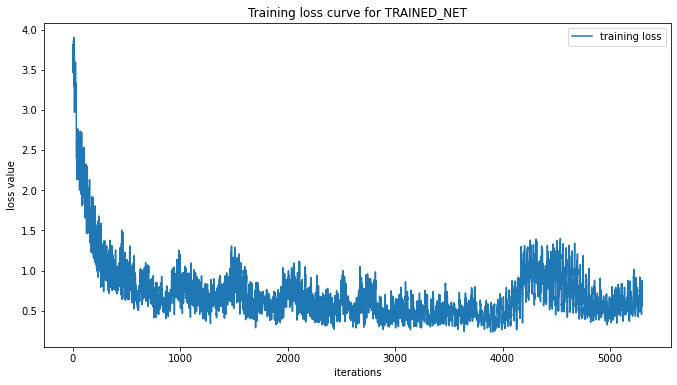

In [39]:
%%time
if TRAINING:
    EPOCH = 100
    trained_net = URSONet()
    if USE_GPU:
        trained_net = trained_net.cuda()
    optimizer = get_optimizer(trained_net)
    # switch to train mode
    trained_net.train()

    print("Starting Training...")

    loss_graph = []

    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
    ax = fig.add_subplot(1,1,1)


    for e in range(EPOCH):
        loss = train(train_loader, trained_net, optimizer, loss_graph)
        ax.clear()
        ax.set_xlabel('iterations')
        ax.set_ylabel('loss value')
        ax.set_title('Training loss curve for TRAINED_NET')
        ax.plot(loss_graph, label='training loss')
        ax.legend(loc='upper right')
        fig.canvas.draw()
        print("Epoch: {} Loss: {}".format(e, loss))

## Testing

In [44]:
def evaluate(val_loader, net):
    total_loss = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, target, _ = data

            if USE_GPU:
                inputs = inputs.cuda()
                target = target.cuda()

            att_gt = target[:, :4].float()
            v_gt, theta_gt = q_to_aa(att_gt)

            # e_gt = dcm_to_euler321_batch(quat2dcm_batch(att_gt))
            # e_gt = e_gt.to(device='cuda')
            t_gt = target[:, 4:7].float()

            # t, att = net(inputs)
            att = net(inputs)
            theta_pred = att[:,0]
            v_pred = att[:,1:]
            L_att = aa_loss(theta_pred, v_pred, theta_gt, v_gt)

            # L_t = translation_loss(t_gt, t)
            # L_att = eulerLoss(e_gt, att)
            # L_att = mrp_loss(att_gt, att)
            # print(1-torch.norm(att))
            # total_loss += L_t + L_att# + 1.2*(torch.abs(1 - torch.norm(att)))
            total_loss = L_att

    return total_loss / len(val_loader)

In [45]:
# switch to evaluation mode
# TODO: need more informative metric
trained_net.eval()
test_loss = evaluate(test_loader, trained_net)
print("Test error: {}".format(test_loss))

Test error: 0.010604145005345345


aa v theta gt:  tensor([[0.4307, 0.5699, 0.6998]], device='cuda:0') tensor([-2.2177], device='cuda:0')
aa v theta pred:  tensor([[0.1848, 0.1333, 0.1198]], device='cuda:0', grad_fn=<SliceBackward>) tensor([-1.0554], device='cuda:0', grad_fn=<SelectBackward>)
loss:  tensor(2.4248, device='cuda:0', grad_fn=<DivBackward0>)


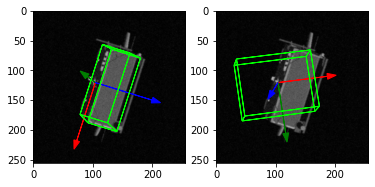

In [60]:
# Compare the learned pose to the ground-truth
%matplotlib inline
idx = 12
img1, label1, K1 = test_dataset[idx]
# label1 = test_dataset.dataset.labels[idx]
if USE_GPU:
    img1 = img1.cuda()
# t_out, att_out = trained_net.forward(img1[None])
# e_out = trained_net.forward(img1[None])
# t_out = t_out.detach().cpu().numpy()[0]
# e_out_cpu = e_out.detach().cpu().numpy()[0]
# att_out = dcm_to_q(euler321_to_dcm(e_out_cpu[0], e_out_cpu[1], e_out_cpu[2]))
att_out = trained_net.forward(img1[None])
theta_pred = att_out[:,0]
v_pred = att_out[:,1:]
img1 = img1.cpu()

size = (256, 256)
vectorScaleFactor = 4
image1, label1 = JointRescrop((256, 256))(tF.to_pil_image(img1), label1.numpy())
fig = plt.figure()
fig.add_subplot(1, 2, 1)
training_dataset.visualize(image1, label1, K1, factor=0.6, bbox=True)

att_gt = torch.Tensor([label1[:4]]).cuda()
v_gt, theta_gt = q_to_aa(att_gt)
t_gt = label1[4:7]
t_out = t_gt
fig.add_subplot(1, 2, 2)
q_out = aa_to_q(v_pred, theta_pred).detach().cpu().numpy()[0]
test_dataset.dataset.visualize(image1, np.concatenate((q_out, t_out)), K1, factor=0.5, bbox=True)
# test_dataset.dataset.visualize(image1, np.concatenate((att_out, t_out)), K1, factor=0.5, bbox=True)
# e_gt = dcm_to_euler321_batch(quat2dcm_batch(att_gt))
# e_gt = e_gt.to(device='cuda')
print("aa v theta gt: ", v_gt, theta_gt)
print("aa v theta pred: ", v_pred, theta_pred)
print("loss: ", aa_loss(theta_pred, v_pred, theta_gt, v_gt))
